#Mounting drive,  Installing libraries and importing them

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
!pip install pyannote.audio==1.1.1
!pip install webrtcvad

     |████████████████████████████████| 235kB 5.7MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 133kB 34.5MB/s 
     |████████████████████████████████| 296kB 39.5MB/s 
     |████████████████████████████████| 1.2MB 32.0MB/s 
     |████████████████████████████████| 81kB 9.4MB/s 
     |████████████████████████████████| 92kB 9.2MB/s 
     |████████████████████████████████| 81kB 8.6MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 143kB 46.9MB/s 
     |████████████████████████████████| 112kB 45.4MB/s 
  Created wheel for pescador: filename=pescador-2.1.0-cp37-none-any.whl size=21077 sha256=7166c9628b269321e4ed732db3ce4d480c9f3ecebf641903243308d7d41c04db
  Stored in directory: /root/.cache/pip/wheels/e7/e7/2d/de501314d1f03d8607aed0f6b48e50d8699f681745003aaa5b
  Created wheel for alemb

In [3]:
import contextlib   
import wave
import librosa
import webrtcvad

import matplotlib.pyplot as plt
import numpy as np

import keras
from keras.layers.core import Dense
from keras.models import Sequential
from keras.layers import Bidirectional, TimeDistributed, Dropout
from keras.layers import LSTM

from sklearn.manifold import TSNE
from sklearn.cluster import MeanShift
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from pyannote.core import Annotation, Segment

from sklearn import preprocessing
import pandas as pd

from pyannote.metrics.diarization import DiarizationErrorRate
from pyannote.metrics.diarization import DiarizationPurity
from pyannote.metrics.diarization import DiarizationCoverage

#Location of Best Model & Audio clip

In [6]:
h5_model_file = '/content/drive/My Drive/Hindi/model_hindi_2.h5' #the path where best model is stored
audiofile = '/content/drive/My Drive/Hindi/Test/Hindi_01.wav'  #the path where test audio clip is stored
annotation_path = '/content/drive/My Drive/Hindi/Test/hindi_annotations1.csv' #the path where test annotation csv file is stored

import sys
sys.path.append('/content/drive/MyDrive/Hindi/scripts') #the path where python scripts are stored


#Loading the best trained Model

In [7]:
%tensorflow_version 1.x

model = Sequential()

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(TimeDistributed(Dense(32)))
model.add(TimeDistributed(Dense(32)))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))

model.build(input_shape=(None, 137, 35))
model.summary()


model.load_weights(h5_model_file)

TensorFlow is already loaded. Please restart the runtime to change versions.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 137, 256)          167936    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 137, 256)          394240    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 137, 32)           8224      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 137, 32)           1056      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 137, 1)            33        
Total params: 571,489
Trainable params: 571,489
Non-trainable params: 0
_________________________________________________________________


# Importing Voice Activity Detection Module

In [8]:
#Importing functions from script containing Voice Activity Detection
import vad
from vad import *

voice = fxn(audiofile)

sample rate 48000


# Importing Segementation Module 

### Then segmenting the audio files on basis of speakers


(35, 78497)
(2305, 137, 35)
(2305, 137, 1)


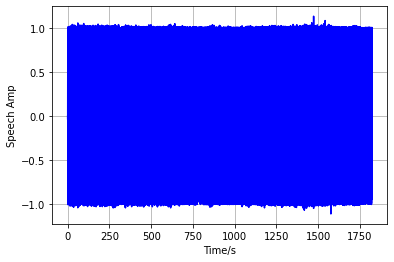

In [9]:
import segmentation
from segmentation import *

segmented = multi_segmentation(audiofile,model)

gp = group_intervals(voice)
splt = spliting(segmented,gp)
resegmented = final_reseg(splt)


# Importing Embeddings Generation Module 

### Then generating the embedding of the segmented file obtained from above 


In [10]:
import Embedding
from Embedding import *

embeddings = embeddings_(audiofile,resegmented,2)

Downloading: "https://github.com/pyannote/pyannote-audio/archive/master.zip" to /root/.cache/torch/hub/master.zip


/usr/local/lib/python3.7/dist-packages/pyannote/audio/embedding/approaches/arcface_loss.py:170: FutureWarning:

The 's' parameter is deprecated in favor of 'scale', and will be removed in a future release



# Importing Embeddings Generation Module 

### Then generating clusters and assigning them with resoective Speaker_id


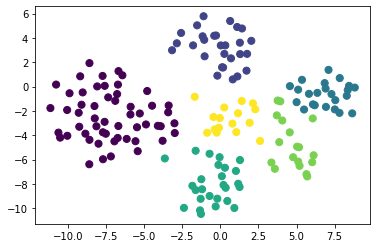

In [11]:
import mean_shift
from mean_shift import *

speak_id , n_speakers = clustering(embeddings)
label_list = []
alpha = 'A'
for i in range(0, n_speakers): 
    label_list.append(alpha) 
    alpha = chr(ord(alpha) + 1) 
lb = preprocessing.LabelEncoder()
label_hyp = lb.fit(label_list)
speaker_id = lb.inverse_transform(speak_id)
hyp_df = pd.DataFrame({'Speaker_id': speaker_id,'Offset': resegmented[:, 0], 'end': resegmented[:, 1]})
result_hypo = hypothesis_gen(hyp_df)  

In [12]:
#Evaluation (DER)

df = pd.read_csv(annotation_path)
ref_df = df[df['filename'] == 'Hindi_01']
ref_df = ref_df.assign(end = ref_df.Offset + ref_df.Duration)
ref_df = ref_df[['Speaker_id','Offset','end']]
ref_records = ref_df.to_records(index=False)
ref_rec = list(ref_records)
reference = Annotation()
for i in range(len(ref_rec)-1):
  reference[Segment(ref_rec[i][1], ref_rec[i][2])] = ref_rec[i][0]

diarizationErrorRate = DiarizationErrorRate()
print("DER = {0:.3f}".format(diarizationErrorRate(reference, result_hypo)))

DER = 0.222


/usr/local/lib/python3.7/dist-packages/pyannote/metrics/utils.py:184: UserWarning:

'uem' was approximated by the union of 'reference' and 'hypothesis' extents.



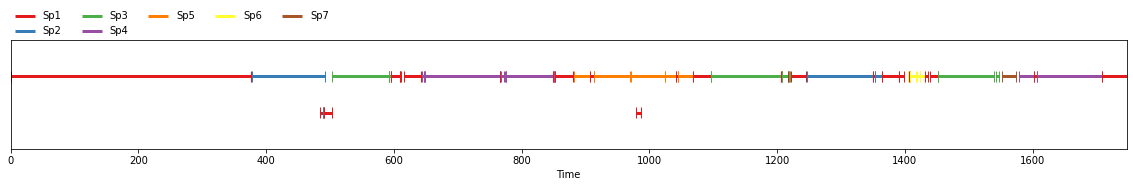

In [13]:
reference

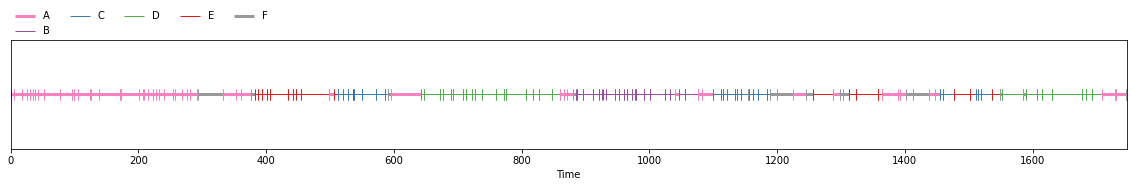

In [14]:
result_hypo